In [183]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

pd.set_option("display.max.columns", 100)
import pylab as plt

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)

In [184]:
df = pd.read_csv("/Users/user/Documents/Study/Data Sience/job_skills.csv")

Проверим, все ли нормально считалось – посмотрим на первые 5 строк.

In [185]:
df.head()

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
0,Google,Google Cloud Program Manager,Program Management,Singapore,"Shape, shepherd, ship, and show technical prog...",BA/BS degree or equivalent practical experienc...,Experience in the business technology market a...
1,Google,"Supplier Development Engineer (SDE), Cable/Con...",Manufacturing & Supply Chain,"Shanghai, China",Drive cross-functional activities in the suppl...,BS degree in an Engineering discipline or equi...,"BSEE, BSME or BSIE degree.\nExperience of usin..."
2,Google,"Data Analyst, Product and Tools Operations, Go...",Technical Solutions,"New York, NY, United States",Collect and analyze data to draw insight and i...,"Bachelor’s degree in Business, Economics, Stat...",Experience partnering or consulting cross-func...
3,Google,"Developer Advocate, Partner Engineering",Developer Relations,"Mountain View, CA, United States","Work one-on-one with the top Android, iOS, and...",BA/BS degree in Computer Science or equivalent...,"Experience as a software developer, architect,..."
4,Google,"Program Manager, Audio Visual (AV) Deployments",Program Management,"Sunnyvale, CA, United States",Plan requirements with internal customers.\nPr...,BA/BS degree or equivalent practical experienc...,CTS Certification.\nExperience in the construc...


Посмотрим на размер данных и названия признаков.

In [186]:
print(df.shape)
print(df.columns.values)

(1250, 7)
['Company' 'Title' 'Category' 'Location' 'Responsibilities'
 'Minimum Qualifications' 'Preferred Qualifications']


In [187]:
df.describe()

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
count,1250,1250,1250,1250,1235,1236,1236
unique,2,794,23,92,801,807,821
top,Google,Business Intern 2018,Sales & Account Management,"Mountain View, CA, United States",Responsibilities and detailed projects will be...,Must be pursuing a full-time MBA program with ...,"Previous internship experience in Sales, Adver..."
freq,1227,35,168,190,33,32,32


In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Company                   1250 non-null   object
 1   Title                     1250 non-null   object
 2   Category                  1250 non-null   object
 3   Location                  1250 non-null   object
 4   Responsibilities          1235 non-null   object
 5   Minimum Qualifications    1236 non-null   object
 6   Preferred Qualifications  1236 non-null   object
dtypes: object(7)
memory usage: 68.5+ KB


## Визуальный анализ данных

Text(0.5, 1.0, 'Names of the companies')

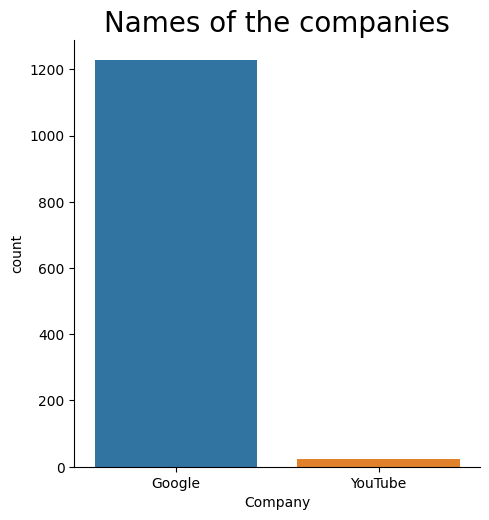

In [189]:
sns.catplot(x="Company", data=df, kind="count")
plt.title('Names of the companies', fontsize=20)

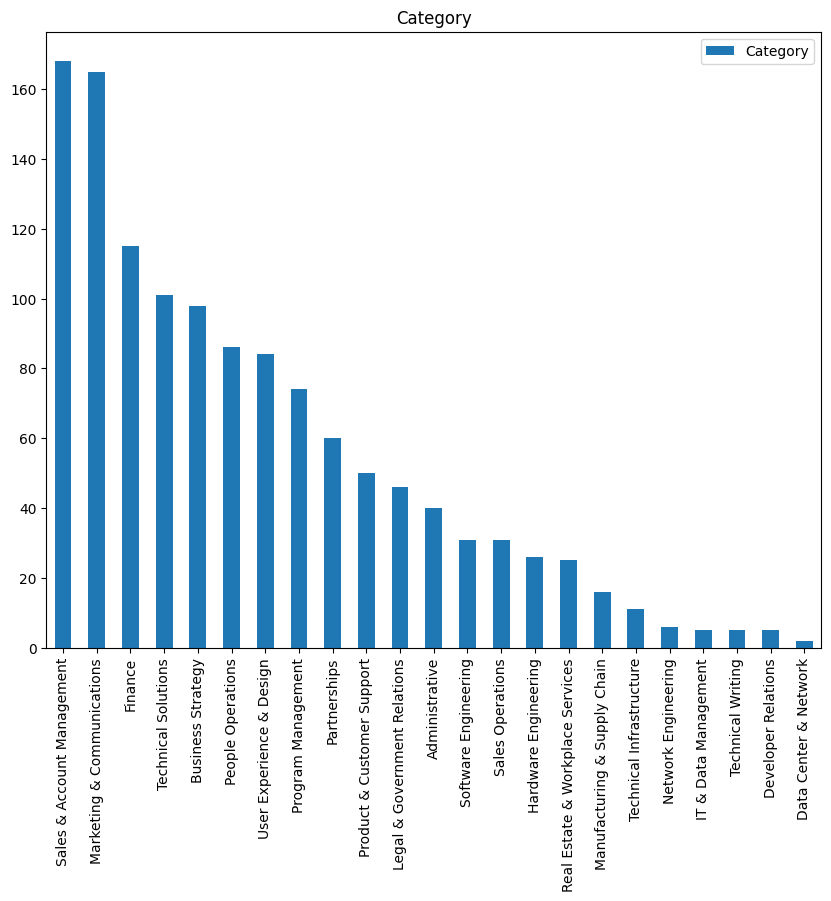

In [190]:
df["Category"].value_counts().plot(kind="bar", label="Category")
plt.legend()
plt.title("Category");

Видим,что большинство работает в сфере продаж и менеджмента

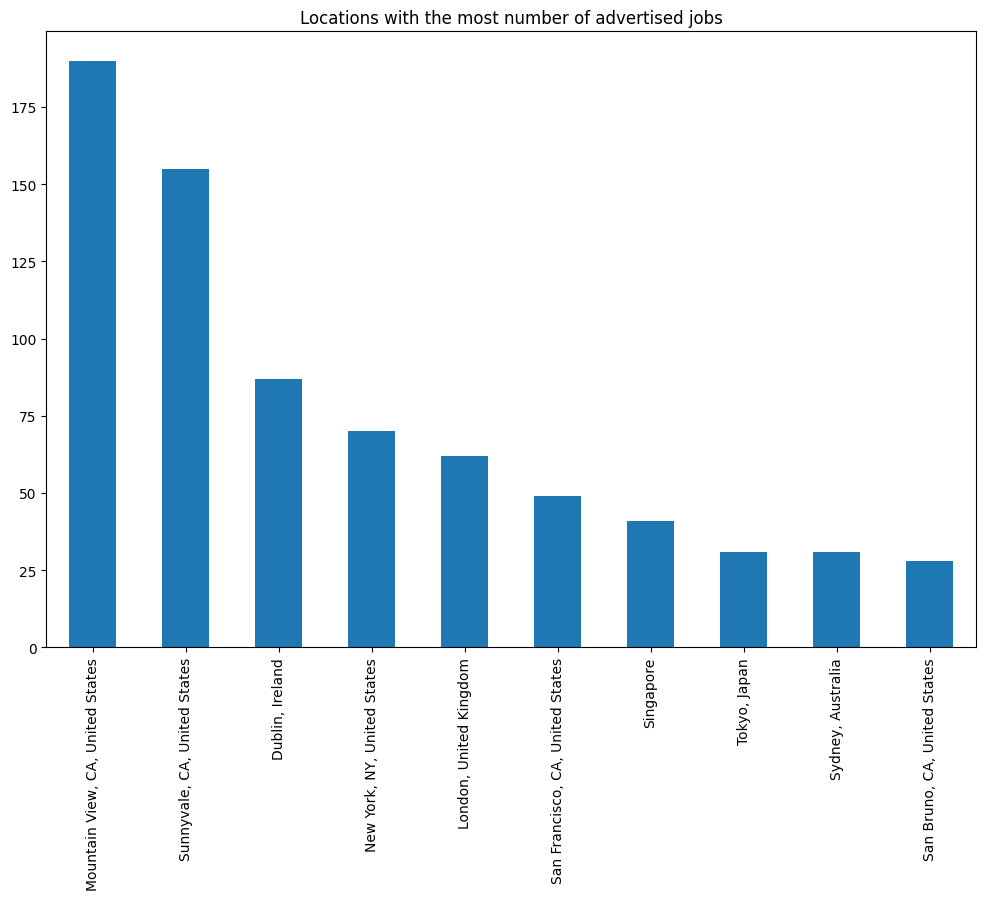

In [191]:
bb = df['Location'].value_counts()
location = pd.DataFrame(bb)
location.head(10).plot.bar(legend='', figsize=(12,8), title='Locations with the most number of advertised jobs')
plt.show()

Большнинство сотрудников работает в Mountain View USA

# Очистка данных

created missing indicator for: Responsibilities
created missing indicator for: Minimum Qualifications
created missing indicator for: Preferred Qualifications


<AxesSubplot: xlabel='index'>

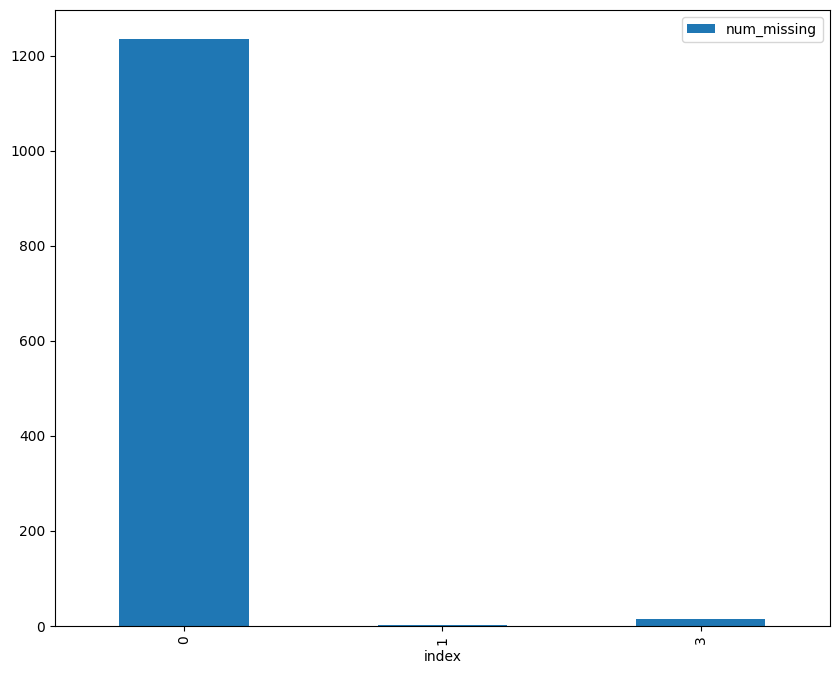

In [192]:
# сначала создаем индикатор для признаков с пропущенными данными
for col in df.columns:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        print('created missing indicator for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing


# затем на основе индикатора строим гистограмму
ismissing_cols = [col for col in df.columns if 'ismissing' in col]
df['num_missing'] = df[ismissing_cols].sum(axis=1)

df['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')

    


In [193]:
# отбрасываем строки с большим количеством пропусков
ind_missing = df[df['num_missing'] > 1].index
df = df.drop(ind_missing, axis=0)

<AxesSubplot: xlabel='index'>

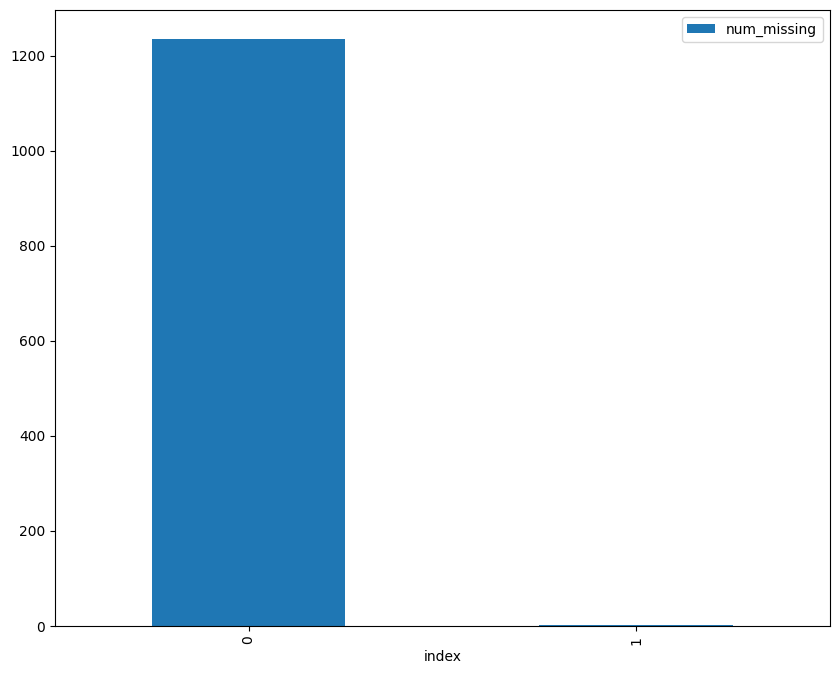

In [194]:
# результат очистки
ismissing_cols = [col for col in df.columns if 'ismissing' in col]
df['num_missing'] = df[ismissing_cols].sum(axis=1)

df['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')


# Класстеризация

In [195]:
from scipy.cluster.vq import kmeans, vq
from numpy import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import _stop_words
from spacy.lang.en.stop_words import STOP_WORDS

In [196]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [197]:
stop_words_0 = set(stopwords.words('english')) 
stop_words = ['and', 'in', 'of', 'or', 'with','to','on','a']

def remove_noise(text):
    tokens = word_tokenize(text)
    clean_tokens = []
    lemmatizer=WordNetLemmatizer()
    for token in tokens:
        token = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+', '', token)
        token = lemmatizer.lemmatize(token.lower())
        if len(token) > 1 and token not in stop_words_0 and token not in stop_words:
            clean_tokens.append(token)
            
    return clean_tokens

In [198]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100,tokenizer=remove_noise)

# Use the .fit_transform() method on the list plots
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Minimum Qualifications'])

In [199]:
cluster_centers, distortion = kmeans(tfidf_matrix.todense(),13)

# Сгенерируем термины из объекта tfidf_vectorizer
terms = tfidf_vectorizer.get_feature_names_out()

for i in range(10):
    # Отсортируем термины
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    print(sorted_terms[:5])

['relevant', 'experience', 'work', 'year', 'equivalent']
['speak', 'fluently', 'idiomatically', 'write', 'english']
['corporate', 'experience', 'year', 'babs', 'equivalent']
['2018', 'june', 'program', 'december', 'united']
['experience', 'industry', 'technology', 'engineering', 'field']
['experience', 'babs', 'equivalent', 'practical', 'degree']
['design', 'interaction', 'experience', 'field', 'science']
['data', 'experience', 'statistic', 'analysis', 'sql']
['student', 'internship', '2018', 'fulltime', 'program']
['marketing', 'experience', 'year', 'equivalent', 'medium']


Видем, что для разных областей - разные кластеры с ключевыми словами